In [1]:
# Extract rois
# Make crops
import tifffile as tiff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import feature, filters, morphology, transform
from skimage.feature import peak_local_max
from skimage.filters import gaussian
from skimage.feature import peak_local_max, blob_dog, blob_log
from skimage.morphology import white_tophat, black_tophat, disk
from tqdm.notebook import tqdm
from scipy import ndimage

In [23]:
def create_circular_kernel(radius):
    """Create a circular kernel with the given radius."""
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x**2 + y**2 <= radius**2
    kernel = np.zeros((2*radius+1, 2*radius+1))
    kernel[mask] = 1
    return kernel

# Function to detect ROIs using convolution with circular kernel
def detect_rois_with_kernel(image, kernel_radius, min_distance=10, threshold_rel=0.5, sigma=1):
    """
    Detect ROIs using circular kernel convolution and local maxima detection.
    
    Parameters:
    - image: 2D numpy array, input image
    - kernel_radius: radius of the circular kernel
    - min_distance: minimum distance between peaks in local maxima detection
    - threshold_rel: relative threshold for peak detection
    
    Returns:
    - coordinates: array of (y, x) coordinates of detected ROIs
    - response_image: convolution response image
    """
    smooth_img = gaussian(image, sigma)
    
    # Create the circular kernel
    kernel = create_circular_kernel(kernel_radius)
    
    # Perform convolution
    response = ndimage.convolve(smooth_img, kernel)
    
    # Find local maxima
    coordinates = peak_local_max(
        response, 
        min_distance=min_distance,
        threshold_rel=threshold_rel
    )
    
    return coordinates, response

# Function to visualize results
def visualize_rois(image, coordinates, response=None, figsize=(15, 5)):
    """Visualize the detected ROIs on the image."""
    fig, axes = plt.subplots(1, 2 if response is not None else 1, figsize=figsize)
    
    if response is not None:
        ax = axes[0]
    else:
        ax = axes
    
    # Show original image with ROIs
    ax.imshow(image, cmap='gray')
    ax.plot(coordinates[:, 1], coordinates[:, 0], 'r+', markersize=10)
    ax.set_title(f'Detected ROIs: {len(coordinates)}')
    ax.axis('off')
    
    # Show convolution response if available
    if response is not None:
        axes[1].imshow(response, cmap='viridis')
        axes[1].set_title('Convolution Response')
        axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()


def detect_rois_with_log(image, min_sigma=1, max_sigma=10, num_sigma=5, threshold=0.1):
    """
    Detect ROIs using Laplacian of Gaussian (LoG) at multiple scales.
    
    Parameters:
    - image: 2D numpy array, input image
    - min_sigma: minimum sigma for the Gaussian kernel
    - max_sigma: maximum sigma for the Gaussian kernel
    - num_sigma: number of intermediate sigmas to use
    - threshold: absolute threshold for blob detection
    
    Returns:
    - blobs: array of (y, x, sigma) coordinates of detected ROIs
    """
    # Normalize image for better results
    img_norm = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    # Apply LoG detection
    blobs = blob_log(
        img_norm, 
        min_sigma=min_sigma, 
        max_sigma=max_sigma, 
        num_sigma=num_sigma, 
        threshold=threshold
    )
    
    return blobs

def enhanced_preprocessing(image, sigma=2, scale=1):
    """
    Enhanced preprocessing pipeline with multiple techniques.
    
    Parameters:
    - image: input image
    - sigma: Gaussian smoothing sigma
    
    Returns:
    - processed: processed image ready for ROI detection
    """
    resized = transform.rescale(image, scale) if scale < 1.0 else image
    
    # 1. Apply Gaussian smoothing
    smoothed = filters.gaussian(resized, sigma=sigma)
    
    # 2. Apply background correction
    bg_corrected = rolling_ball_background(smoothed, radius=15)
    
    # 3. Enhance small features with top-hat
    enhanced = enhance_with_tophat(bg_corrected, radius=5)
    
    # 4. Apply contrast stretching
    p2, p98 = np.percentile(enhanced, (2, 98))
    processed = np.clip((enhanced - p2) / (p98 - p2), 0, 1)
    
    return processed

def rolling_ball_background(image, radius=50):
    """
    Perform rolling ball background subtraction.
    
    Parameters:
    - image: input image
    - radius: radius of the rolling ball (structuring element)
    
    Returns:
    - corrected: background-corrected image
    """
    # Create a disk-shaped structuring element
    selem = disk(radius)
    
    # Apply morphological opening (erosion followed by dilation)
    background = morphology.opening(image, selem, out=None)
    
    # Subtract background from original image
    corrected = image - background
    min_val = np.min(corrected)
    range_val = np.max(corrected) - min_val
    # Normalize to 0-1 range
    corrected = (corrected - min_val) / range_val
    
    return corrected

def enhance_with_tophat(image, radius=15):
    """
    Enhance small features using white top-hat transform.
    
    Parameters:
    - image: input image
    - radius: radius of the structuring element
    
    Returns:
    - enhanced: top-hat transformed image
    """
    # Create a disk-shaped structuring element
    selem = disk(radius)
    
    # Apply white top-hat transform (original - opening)
    enhanced = white_tophat(image, selem)
    
    return enhanced


def crop_windows(imgs, center_x, center_y, window_size, t, length):
    # Check if number is even, add one if so
    # if window_size%2 == 0:
    #     window_size += 1
    center_x = int(center_x)
    center_y = int(center_y)
    
    half_window_size = window_size // 2
    x_from = max(center_x - half_window_size, 0)
    x_to = min(center_x + half_window_size, imgs.shape[1])
    y_from = max(center_y - half_window_size, 0)
    y_to = min(center_y + half_window_size, imgs.shape[0])
    t_end = min(t + length, imgs.shape[2])
    window = imgs[t:t_end, y_from:y_to, x_from:x_to]

    return window
    
def crop_window(img, center_x, center_y, window_size):
    # Check if number is even, add one if so
    # if window_size%2 == 0:
    #     window_size += 1
    center_x = int(center_x)
    center_y = int(center_y)
    half_window_size = window_size // 2
    x_from = max(center_x - half_window_size, 0)
    x_to = min(center_x + half_window_size, img.shape[1])
    y_from = max(center_y - half_window_size, 0)
    y_to = min(center_y + half_window_size, img.shape[0])
    window = img[y_from:y_to, x_from:x_to]

    return window

In [4]:
# Simple approach
imgs = tiff.imread("/mnt/imaging.data/PertzLab/apoDetection/TIFFs/Exp09_Site12.tif")
times = range(len(imgs))

# Create empty dataframe
all_pos_df = pd.DataFrame(columns=['Y', 'X', 'radius', 't'])

pos_dfs = []

for t, frame in tqdm(enumerate(imgs), total=len(imgs)):
    centroids, _ = detect_rois_with_kernel(frame, 6, min_distance=12, threshold_rel=0.1, sigma=2)

    if len(centroids) > 0:
        pos_array = np.array(centroids)
        pos_df = pd.DataFrame(centroids, columns=['y', 'x'])
        pos_df['frame'] = t
        pos_dfs.append(pos_df)
        
        #all_pos_df = pd.concat([all_pos_df, pos_df], ignore_index=True)

all_pos_df = pd.concat(pos_dfs, ignore_index=True) if pos_dfs else pd.DataFrame(columns=['y', 'x', 'frame']) 
        
# Takes around 5mins, did not try downsampling yet (1450x1024x1024)

  0%|          | 0/1450 [00:00<?, ?it/s]

Frame 1449: 480 trajectories present.


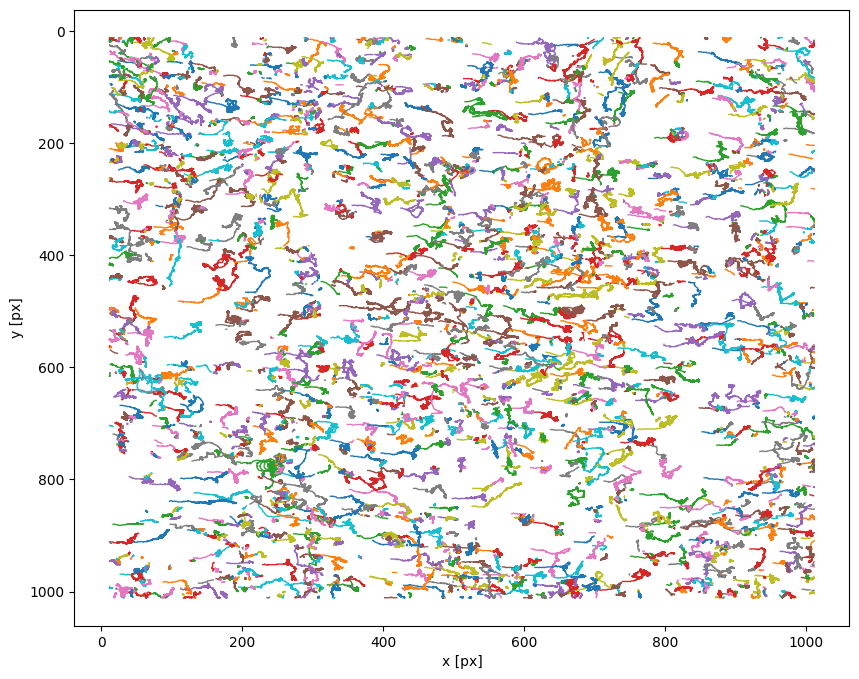

In [5]:
import trackpy as tp

linked = tp.link_df(all_pos_df, search_range=5, memory=3)
trajectories = tp.filter_stubs(linked, threshold=5)
track_stats = tp.compute_drift(trajectories)

# 4. For visualizing tracks
fig, ax = plt.subplots(figsize=(10, 8))
tp.plot_traj(trajectories)
plt.show()

In [9]:
trajectories_no_index = trajectories.reset_index(drop=True)


df_napari = (
    trajectories_no_index
    .rename(columns={'frame': 't', 'particle': 'track_id'})
    [['track_id', 't', 'y', 'x']]
)

df_napari.to_csv("test_tracks.csv", index=False)

In [12]:
traj_renamed = trajectories_no_index.rename(columns={'frame': 't', 'particle': 'track_id'})

## Plot

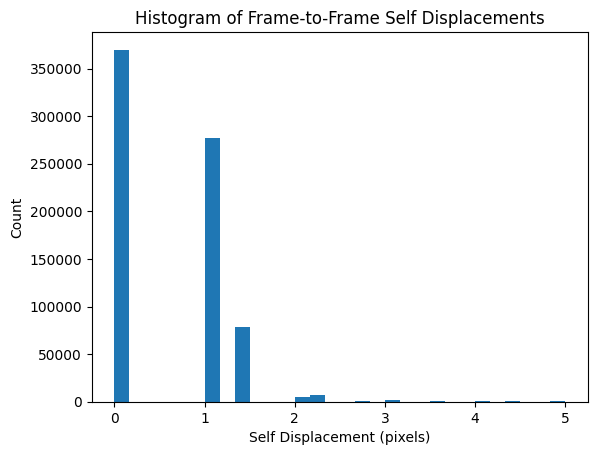

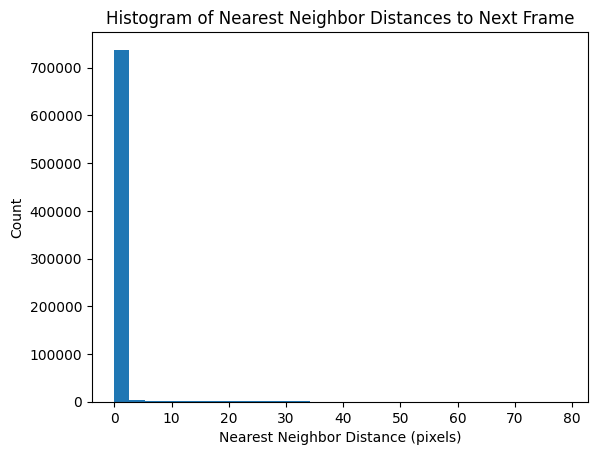

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

# Load your tracks data
# Replace 'tracks_data.csv' with your actual file path
df = traj_renamed

# Ensure the DataFrame has the required columns
df = df[['track_id', 't', 'y', 'x']]

# 1) Compute self-displacement (frame-to-frame for same particle)
df_sorted = df.sort_values(['track_id', 't'])
df_sorted['y_prev'] = df_sorted.groupby('track_id')['y'].shift(1)
df_sorted['x_prev'] = df_sorted.groupby('track_id')['x'].shift(1)
df_sorted['t_prev'] = df_sorted.groupby('track_id')['t'].shift(1)

# Filter for consecutive frames
mask = (df_sorted['t'] - df_sorted['t_prev'] == 1)
df_disp = df_sorted[mask].copy()
df_disp['self_dist'] = np.sqrt((df_disp['y'] - df_disp['y_prev'])**2 +
                               (df_disp['x'] - df_disp['x_prev'])**2)

# 2) Compute nearest neighbor displacement (between different particles)
# For each frame t, build KD-tree of positions at t+1 and query positions at t
nn_dists = []
for t in df['t'].unique():
    coords_t = df[df['t'] == t][['y', 'x']].values
    coords_t1 = df[df['t'] == t + 1][['y', 'x']].values
    if len(coords_t) and len(coords_t1):
        tree = cKDTree(coords_t1)
        dists, _ = tree.query(coords_t, k=1)
        nn_dists.extend(dists)

# 3) Plot histogram of self-displacements
plt.figure()
plt.hist(df_disp['self_dist'], bins=30)
plt.xlabel('Self Displacement (pixels)')
plt.ylabel('Count')
plt.title('Histogram of Frame-to-Frame Self Displacements')
plt.show()

# 4) Plot histogram of nearest neighbor distances
plt.figure()
plt.hist(nn_dists, bins=30)
plt.xlabel('Nearest Neighbor Distance (pixels)')
plt.ylabel('Count')
plt.title('Histogram of Nearest Neighbor Distances to Next Frame')
plt.show()


Computing self-displacements...
Computing nearest neighbor displacements...


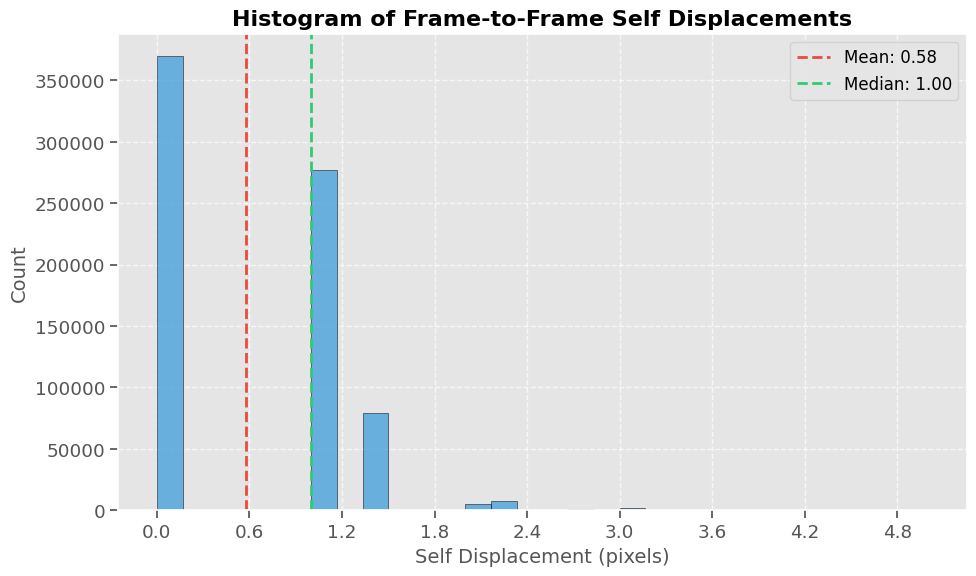

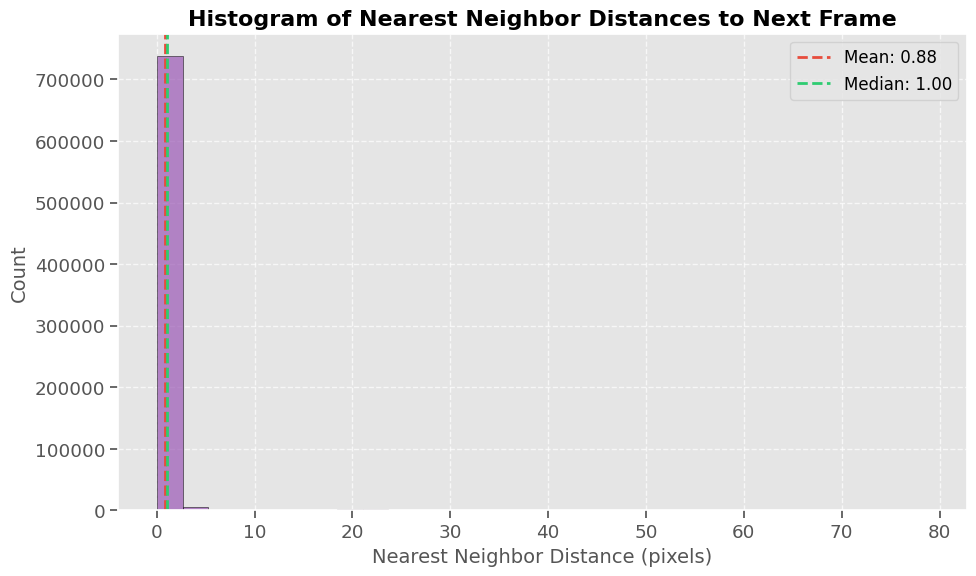

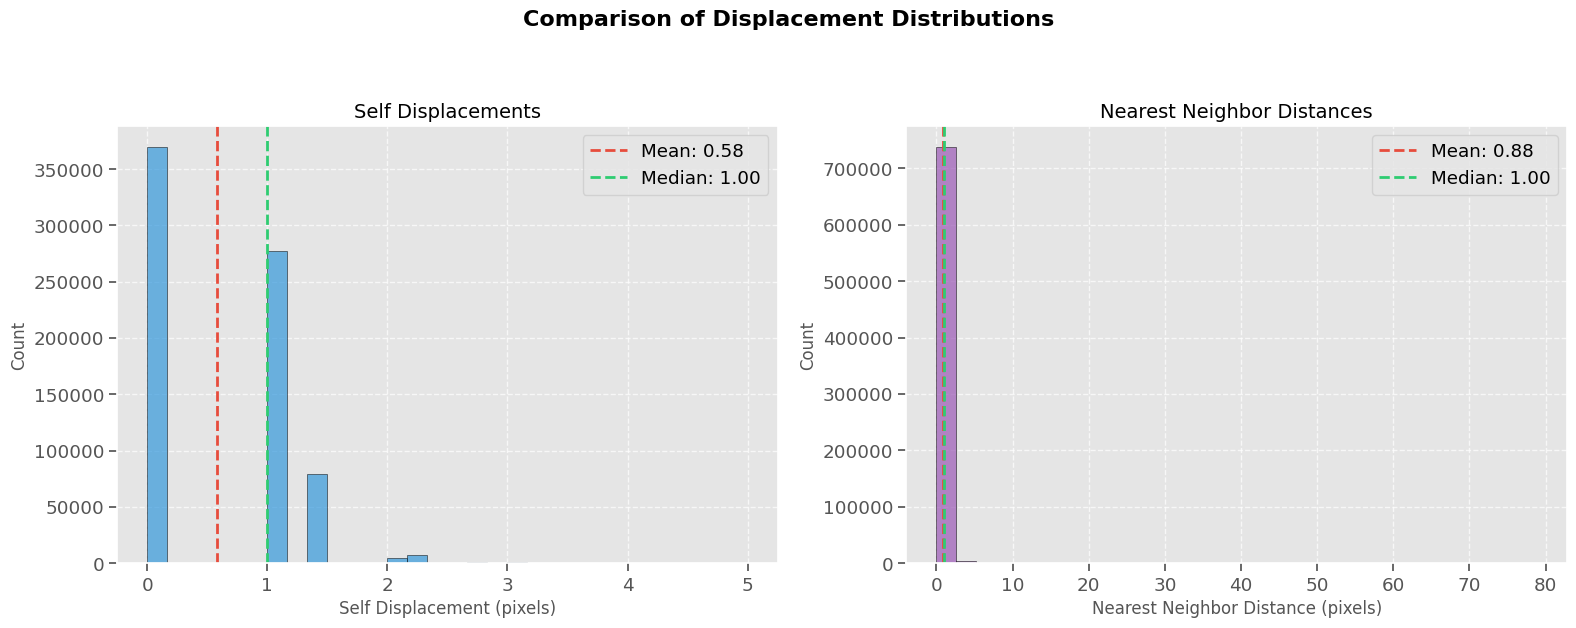


Summary Statistics:
Self Displacement - Mean: 0.58, Median: 1.00, Max: 5.00
Nearest Neighbor  - Mean: 0.88, Median: 1.00, Max: 78.85


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import cKDTree
from matplotlib.ticker import MaxNLocator

# Set the style for nicer plots
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)

# Load your tracks data
# Replace 'tracks_data.csv' with your actual file path
df = traj_renamed

# Ensure the DataFrame has the required columns
df = df[['track_id', 't', 'y', 'x']]

# 1) Compute self-displacement (frame-to-frame for same particle)
print("Computing self-displacements...")
df_sorted = df.sort_values(['track_id', 't'])
df_sorted['y_prev'] = df_sorted.groupby('track_id')['y'].shift(1)
df_sorted['x_prev'] = df_sorted.groupby('track_id')['x'].shift(1)
df_sorted['t_prev'] = df_sorted.groupby('track_id')['t'].shift(1)

# Filter for consecutive frames
mask = (df_sorted['t'] - df_sorted['t_prev'] == 1)
df_disp = df_sorted[mask].copy()
df_disp['self_dist'] = np.sqrt((df_disp['y'] - df_disp['y_prev'])**2 +
                               (df_disp['x'] - df_disp['x_prev'])**2)

# 2) Compute nearest neighbor displacement (between different particles)
print("Computing nearest neighbor displacements...")
nn_dists = []
for t in sorted(df['t'].unique()):
    coords_t = df[df['t'] == t][['y', 'x']].values
    coords_t1 = df[df['t'] == t + 1][['y', 'x']].values
    if len(coords_t) > 0 and len(coords_t1) > 0:
        tree = cKDTree(coords_t1)
        dists, _ = tree.query(coords_t, k=1)
        nn_dists.extend(dists)

# 3) Plot histogram of self-displacements
fig, ax = plt.subplots(figsize=(10, 6))
n, bins, patches = ax.hist(
    df_disp['self_dist'], 
    bins=30, 
    color='#3498db', 
    alpha=0.7,
    edgecolor='black', 
    linewidth=0.5
)

# Calculate statistics
mean_self = np.mean(df_disp['self_dist'])
median_self = np.median(df_disp['self_dist'])

# Add vertical lines for mean and median
ax.axvline(mean_self, color='#e74c3c', linestyle='dashed', linewidth=2, 
           label=f'Mean: {mean_self:.2f}')
ax.axvline(median_self, color='#2ecc71', linestyle='dashed', linewidth=2, 
           label=f'Median: {median_self:.2f}')

# Improve labeling and appearance
ax.set_xlabel('Self Displacement (pixels)', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Histogram of Frame-to-Frame Self Displacements', fontsize=16, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(frameon=True, fontsize=12)
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
fig.tight_layout()

# Save the figure
#plt.savefig('self_displacement_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

# 4) Plot histogram of nearest neighbor distances
fig, ax = plt.subplots(figsize=(10, 6))
n, bins, patches = ax.hist(
    nn_dists, 
    bins=30, 
    color='#9b59b6', 
    alpha=0.7,
    edgecolor='black', 
    linewidth=0.5
)

# Calculate statistics for nearest neighbor distances
mean_nn = np.mean(nn_dists)
median_nn = np.median(nn_dists)

# Add vertical lines for mean and median
ax.axvline(mean_nn, color='#e74c3c', linestyle='dashed', linewidth=2, 
           label=f'Mean: {mean_nn:.2f}')
ax.axvline(median_nn, color='#2ecc71', linestyle='dashed', linewidth=2, 
           label=f'Median: {median_nn:.2f}')

# Improve labeling and appearance
ax.set_xlabel('Nearest Neighbor Distance (pixels)', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Histogram of Nearest Neighbor Distances to Next Frame', fontsize=16, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(frameon=True, fontsize=12)
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
fig.tight_layout()

# Save the figure
#plt.savefig('nearest_neighbor_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

# 5) Optional: Plot both histograms side by side for comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Self displacement histogram
axes[0].hist(df_disp['self_dist'], bins=30, color='#3498db', alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0].axvline(mean_self, color='#e74c3c', linestyle='dashed', linewidth=2, label=f'Mean: {mean_self:.2f}')
axes[0].axvline(median_self, color='#2ecc71', linestyle='dashed', linewidth=2, label=f'Median: {median_self:.2f}')
axes[0].set_xlabel('Self Displacement (pixels)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Self Displacements', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend(frameon=True)

# Nearest neighbor histogram
axes[1].hist(nn_dists, bins=30, color='#9b59b6', alpha=0.7, edgecolor='black', linewidth=0.5)
axes[1].axvline(mean_nn, color='#e74c3c', linestyle='dashed', linewidth=2, label=f'Mean: {mean_nn:.2f}')
axes[1].axvline(median_nn, color='#2ecc71', linestyle='dashed', linewidth=2, label=f'Median: {median_nn:.2f}')
axes[1].set_xlabel('Nearest Neighbor Distance (pixels)', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Nearest Neighbor Distances', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend(frameon=True)

plt.suptitle('Comparison of Displacement Distributions', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()

# Save the comparison figure
#plt.savefig('displacement_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Self Displacement - Mean: {mean_self:.2f}, Median: {median_self:.2f}, Max: {df_disp['self_dist'].max():.2f}")
print(f"Nearest Neighbor  - Mean: {mean_nn:.2f}, Median: {median_nn:.2f}, Max: {max(nn_dists):.2f}")

## Crop

In [22]:
duration = 20
step = 5
test_range = range(0, duration+1, step)

for i in test_range:
    print(i)

0
5
10
15
20


In [ ]:
# downsampled and less backgroundsub and less tophat
window_size = 32
t = 0
step = 5
duration = 20
num_images = (duration//step) + 1

track_ids = np.unique(traj_renamed['track_id'])
all_track_windows = []

for track_id in track_ids:
    current_track_df = traj_renamed[traj_renamed['track_id'] == track_id]
    start_t = int(current_track_df['t'].min())
    end_t = int(current_track_df['t'].max())

    if end_t - start_t < step:
        continue
    
    windows_per_track = []
    centroids = []

    last_valid_x = None
    last_valid_y = None


    for i in range(start_t, end_t+1, step):
        current_frame_data = current_track_df[current_track_df['t'] == i]
        img = imgs[i]
        if len(current_frame_data) > 0:
            current_y = current_frame_data['y'].iloc[0]
            current_x = current_frame_data['x'].iloc[0]

            # Update last valid position
            last_valid_x = current_x
            last_valid_y = current_y
            
            window = crop_window(img, current_x, current_y, window_size)
            windows_per_track.append(window)
            centroids.append((i, current_y, current_x))
        elif last_valid_x is not None and last_valid_y is not None:
            window = crop_window(img, last_valid_x, last_valid_y, window_size)
            windows_per_track.append(window)
            centroids.append((i, last_valid_y, last_valid_y))
        else:
            # This case should not occur I think?
            continue

    if len(windows_per_track) >= num_images:
        sliding_windows_per_track = [
            (windows_per_track[i:i+num_images], centroids[i]) 
            for i in range(len(windows_per_track) - num_images + 1)
        ]
        all_track_windows.append((sliding_windows_per_track))

        
    
    
    while t + duration in current_obj_df['t'] and counter < 1000:
        current_windows = []
        for i in range(start_t, start_t+duration+1, step):
            img = imgs[i, :, :]
            current_y = current_obj_df[current_obj_df['t'] == i]['y']
            current_x = current_obj_df[current_obj_df['t'] == i]['x']
            
            window = crop_window(img, current_x, current_y, window_size)
            current_windows.append(window)
        windows_per_track.append(current_windows)
        start_t += step
            
        


num_bad_windows = 0
windows_list = []
for centroid in blobs:
    y = centroid[0]
    x = centroid[1]
    windows = crop_windows(imgs, x, y, window_size, t, duration)
    if windows.shape == (duration, window_size, window_size):
        windows_list.append(windows)
    else:
        num_bad_windows += 1
print(num_bad_windows)
print(len(windows_list))

Frame 1449: 480 trajectories present.


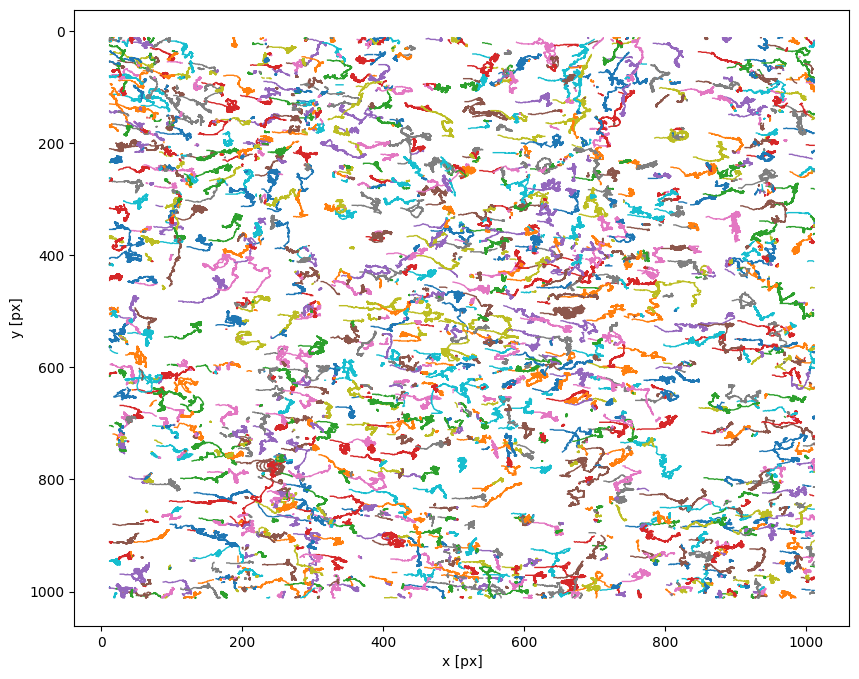

In [57]:
import trackpy as tp

linked = tp.link_df(all_pos_df, search_range=10, memory=3)
trajectories = tp.filter_stubs(linked, threshold=5)
track_stats = tp.compute_drift(trajectories)

# 4. For visualizing tracks
fig, ax = plt.subplots(figsize=(10, 8))
tp.plot_traj(trajectories)
plt.show()

In [59]:
trajectories

y    x  frame  particle
frame_index                           
0            989  429      0         0
0            971  483      0         1
0            261  668      0         2
0            549  829      0         3
0            795   40      0         4
...          ...  ...    ...       ...
1449         851  963   1449      4178
1449         530  660   1449       359
1449         265  730   1449       450
1449         749   35   1449      5312
1449         387  359   1449      5770

[753791 rows x 4 columns]

In [42]:
# with log (takes veery long, needs to be optimized if we want to use it)
imgs = tiff.imread("/mnt/imaging.data/PertzLab/apoDetection/TIFFs/Exp09_Site12.tif")
times = range(len(imgs))

# Create empty dataframe
all_blobs_df = pd.DataFrame(columns=['Y', 'X', 'radius', 't'])

for t, frame in tqdm(enumerate(imgs), total=len(imgs)):
    processed_image = enhanced_preprocessing(frame, scale=0.5)

    blobs = detect_rois_with_log(
        processed_image,
        min_sigma=7,
        max_sigma=12,
        num_sigma=5,
        threshold=0.05
    )

    if len(blobs) > 0:
        blob_array = np.array(blobs)
        blob_df = pd.DataFrame(blob_array, columns=['Y', 'X', 'radius'])
        blob_df['t'] = t

        all_blobs_df = pd.concat([all_blobs_df, blob_df], ignore_index=True)
        
# Takes much longer, scale of 0.5 is not realistic with current settings
# maybe better ways to optimize left

  0%|          | 0/1450 [00:00<?, ?it/s]

/tmp/ipykernel_1796680/2675403269.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_blobs_df = pd.concat([all_blobs_df, blob_df], ignore_index=True)


KeyboardInterrupt: 

In [ ]:
import trackpy as tp

linked = tp.link_df(all_blobs_df, search_range=10, memory=3)
trajectories

In [39]:
t = 0
imgs = tiff.imread("/mnt/imaging.data/PertzLab/apoDetection/TIFFs/Exp09_Site12.tif")
test_image = imgs[0]

processed_image = enhanced_preprocessing(test_image, scale=0.75)

# blobs = detect_rois_with_log(test_image)
blobs = detect_rois_with_log(
    processed_image,
    min_sigma=7,
    max_sigma=12,
    num_sigma=5,
    threshold=0.05
)
# Create a DataFrame
blob_array = np.array(blobs)
blob_df = pd.DataFrame(blob_array, columns=['Y', 'X', 'radius'])
blob_df['t'] = t


In [15]:
blob_array = np.array(blobs)

blob_df = pd.DataFrame(blob_array, columns=['Y', 'X', 'radius'])
blob_df

Y      X  radius
0       0.0  967.0     7.0
1     151.0   96.0     7.0
2     658.0  904.0     7.0
3     316.0  425.0     7.0
4     487.0  339.0     7.0
..      ...    ...     ...
710   442.0    0.0     7.0
711   660.0  773.0     7.0
712   598.0  788.0     9.5
713  1009.0  398.0     7.0
714   353.0    0.0     7.0

[715 rows x 3 columns]

In [14]:
blobs

array([[   0. ,  967. ,    7. ],
       [ 151. ,   96. ,    7. ],
       [ 658. ,  904. ,    7. ],
       ...,
       [ 598. ,  788. ,    9.5],
       [1009. ,  398. ,    7. ],
       [ 353. ,    0. ,    7. ]])

In [40]:
# downsampled and less backgroundsub and less tophat
window_size = 32
t = 0
duration = 25

num_bad_windows = 0
windows_list = []
for centroid in blobs:
    y = centroid[0]
    x = centroid[1]
    windows = crop_windows(imgs, x, y, window_size, t, duration)
    if windows.shape == (duration, window_size, window_size):
        windows_list.append(windows)
    else:
        num_bad_windows += 1
print(num_bad_windows)
print(len(windows_list))

41
613


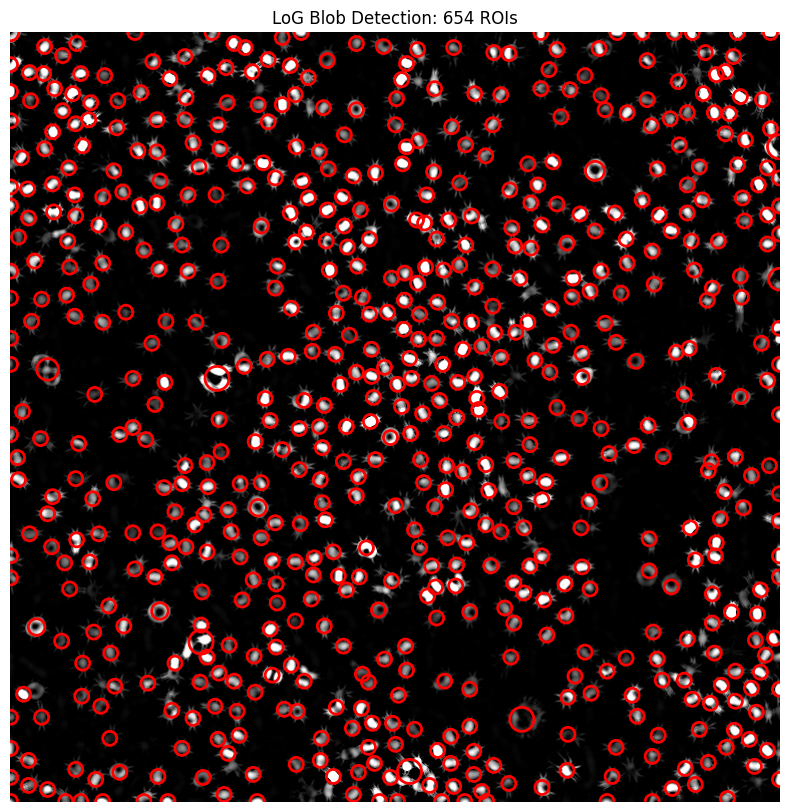

In [41]:
# Visualize LoG detection with tophat
plt.figure(figsize=(10, 10))
plt.imshow(processed_image, cmap='gray')
for y, x, r in blobs:
    circle = plt.Circle((x, y), r, color='r', fill=False, linewidth=2)
    plt.gca().add_patch(circle)
plt.title(f'LoG Blob Detection: {len(blobs)} ROIs')
plt.axis('off')
plt.show()

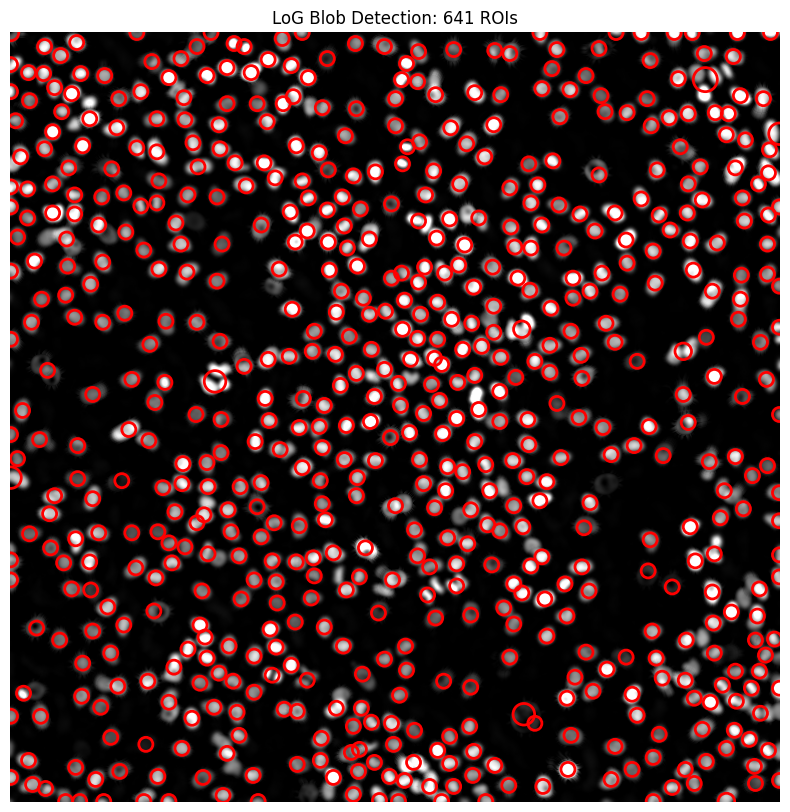

In [33]:
# Visualize LoG detection with tophat
plt.figure(figsize=(10, 10))
plt.imshow(processed_image, cmap='gray')
for y, x, r in blobs:
    circle = plt.Circle((x, y), r, color='r', fill=False, linewidth=2)
    plt.gca().add_patch(circle)
plt.title(f'LoG Blob Detection: {len(blobs)} ROIs')
plt.axis('off')
plt.show()

In [32]:
# With downsampled images
window_size = 32
t = 0
duration = 25

num_bad_windows = 0
windows_list = []
for centroid in blobs:
    y = centroid[0]
    x = centroid[1]
    windows = crop_windows(imgs, x, y, window_size, t, duration)
    if windows.shape == (duration, window_size, window_size):
        windows_list.append(windows)
    else:
        num_bad_windows += 1
print(num_bad_windows)
print(len(windows_list))

37
604


In [10]:
window_size = 32
t = 0
duration = 25

num_bad_windows = 0
windows_list = []
for centroid in blobs:
    y = centroid[0]
    x = centroid[1]
    windows = crop_windows(imgs, x, y, window_size, t, duration)
    if windows.shape == (duration, window_size, window_size):
        windows_list.append(windows)
    else:
        num_bad_windows += 1
print(num_bad_windows)
print(len(windows_list))

71
644


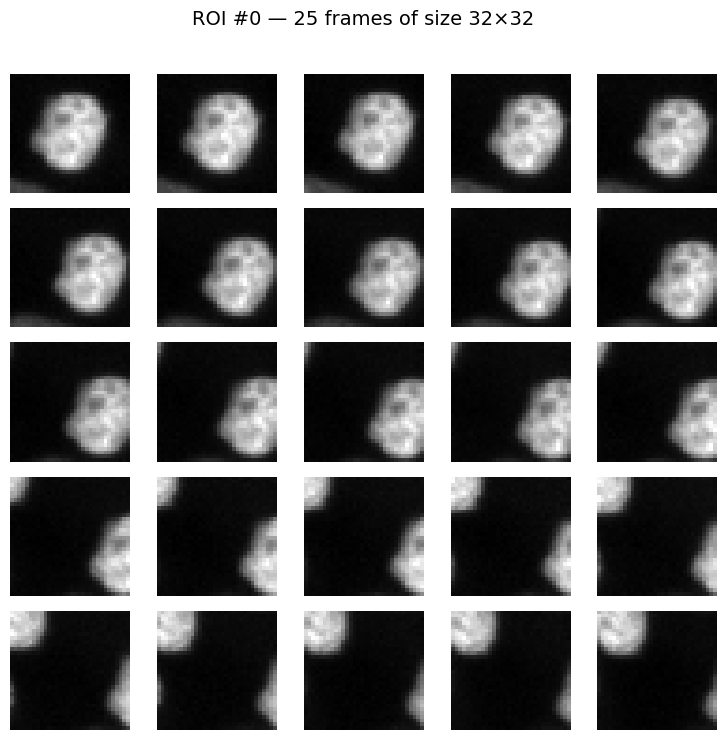

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_roi_windows(windows_list, roi_index=0, cmap='gray'):
    """
    Display the time‑sequence of crops for a given ROI in a square grid.

    Parameters:
    - windows_list: list of arrays, each array shape (T, H, W)
    - roi_index: which ROI to visualize (default 0)
    - cmap: matplotlib colormap (default 'gray')
    """
    # Retrieve the frames for this ROI
    frames = np.array(windows_list[roi_index])
    T, H, W = frames.shape

    # Compute grid size (smallest square that fits T frames)
    grid_n = int(np.ceil(np.sqrt(T)))

    fig, axes = plt.subplots(grid_n, grid_n, figsize=(grid_n*1.5, grid_n*1.5))
    axes = axes.flatten()

    # Plot each frame
    for i in range(grid_n * grid_n):
        ax = axes[i]
        if i < T:
            ax.imshow(frames[i], cmap=cmap)
        ax.axis('off')

    plt.suptitle(f'ROI #{roi_index} — {T} frames of size {H}×{W}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ── Example usage ────────────────────────────────────────────────────────────────
# Make sure you have windows_list defined in your session (e.g. loaded or computed).
# Then call:
visualize_roi_windows(windows_list, roi_index=0)


In [12]:
windows_list[0][0].shape

(32, 32)

In [32]:
window_size = 32

num_bad_windows = 0
windows = []
for centroid in blobs:
    y = centroid[0]
    x = centroid[1]
    window = crop_window(test_image, x, y, window_size)
    if window.shape == (window_size, window_size):
        windows.append(window)
    else:
        num_bad_windows += 1
print(num_bad_windows)
print(len(windows))

71
644


In [29]:
window_size = 32

num_bad_windows = 0
windows = []
for centroid in blobs:
    y = centroid[0]
    x = centroid[1]
    window = crop_window(test_image, x, y, window_size)
    if window.shape == (window_size, window_size):
        windows.append(window)
    else:
        num_bad_windows += 1
print(num_bad_windows)
print(len(windows))

56
600


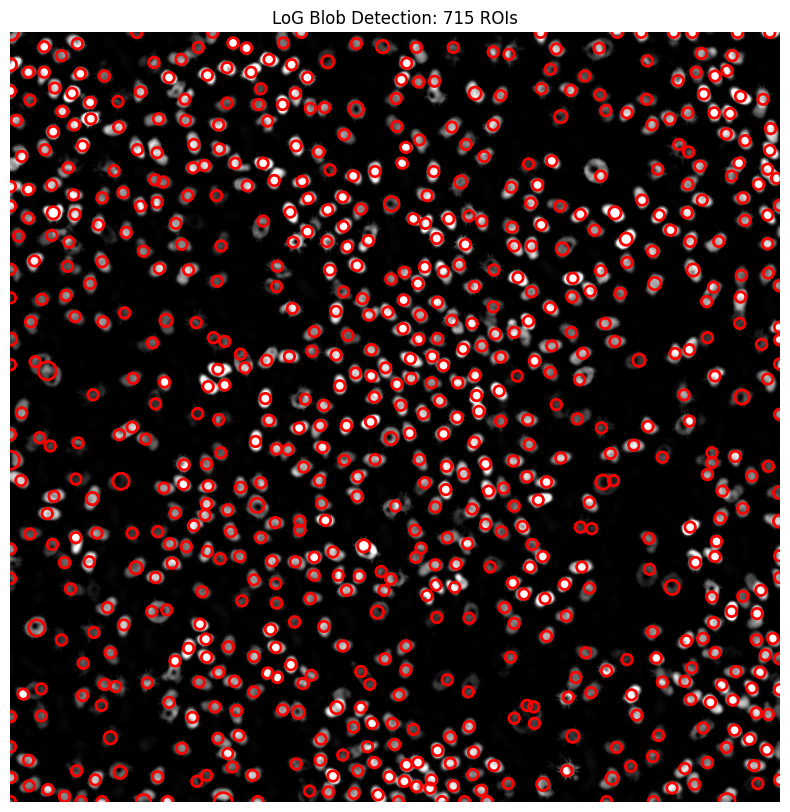

In [33]:
# Visualize LoG detection with tophat
plt.figure(figsize=(10, 10))
plt.imshow(processed_image, cmap='gray')
for y, x, r in blobs:
    circle = plt.Circle((x, y), r, color='r', fill=False, linewidth=2)
    plt.gca().add_patch(circle)
plt.title(f'LoG Blob Detection: {len(blobs)} ROIs')
plt.axis('off')
plt.show()

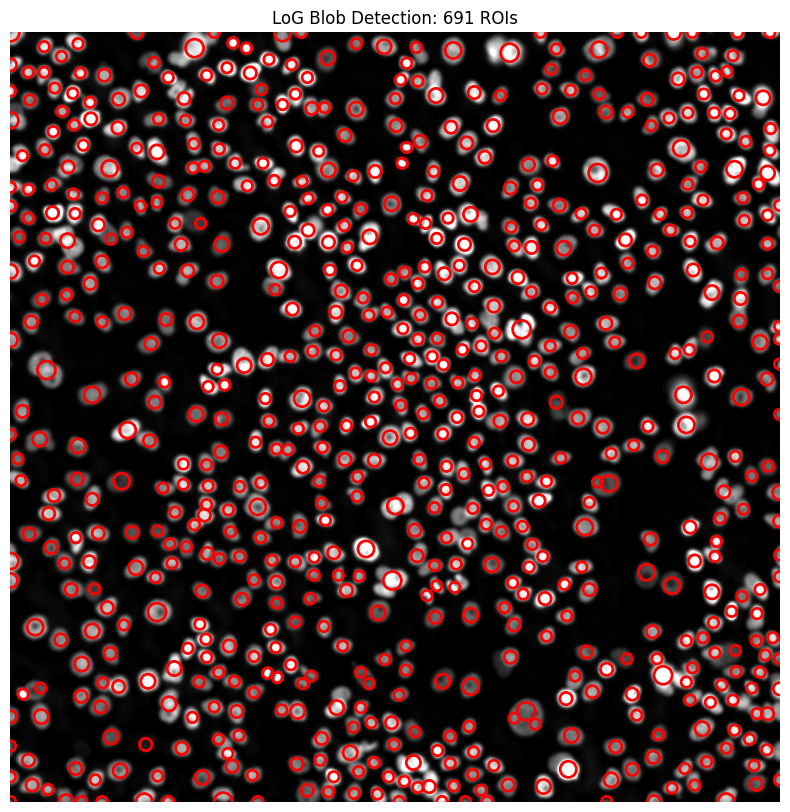

In [26]:
# Visualize LoG detection without tophat
plt.figure(figsize=(10, 10))
plt.imshow(processed_image, cmap='gray')
for y, x, r in blobs:
    circle = plt.Circle((x, y), r, color='r', fill=False, linewidth=2)
    plt.gca().add_patch(circle)
plt.title(f'LoG Blob Detection: {len(blobs)} ROIs')
plt.axis('off')
plt.show()

In [15]:
window_size = 32

num_bad_windows = 0
windows = []
for centroid in blobs:
    y = centroid[0]
    x = centroid[1]
    window = crop_window(test_image, x, y, window_size)
    if window.shape == (window_size, window_size):
        windows.append(window)
    else:
        num_bad_windows += 1
print(num_bad_windows)
print(len(windows))
    # print(f"y: {y}, x: {x}")

56
603


In [4]:
blobs

array([[989.  , 429.  ,   5.5 ],
       [518.  , 479.  ,   5.5 ],
       [981.  , 742.  ,  10.  ],
       ...,
       [621.  , 109.  ,   7.75],
       [154.  , 168.  ,   7.75],
       [507.  , 549.  ,   7.75]])

In [ ]:
# Compare with LoG blob detection
blobs = detect_rois_with_log(
    processed_image,
    min_sigma=7,
    max_sigma=12,
    num_sigma=5,
    threshold=0.05
)

# Visualize LoG detection
plt.figure(figsize=(10, 10))
plt.imshow(processed_image, cmap='gray')
for y, x, r in blobs:
    circle = plt.Circle((x, y), r, color='r', fill=False, linewidth=2)
    plt.gca().add_patch(circle)
plt.title(f'LoG Blob Detection: {len(blobs)} ROIs')
plt.axis('off')
plt.show()